In [2]:
import pandas as pd
import numpy as np
import sympy
import datetime as dt
import time
from math import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from ipyleaflet import *
import folium
import json
import geopy.distance
from haversine import haversine
from tqdm import tqdm_notebook

sns.set()
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
    
import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

import warnings
warnings.filterwarnings("ignore")

In [56]:
from patsy import dmatrix

In [3]:
train = pd.read_csv("../dataset/train.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [6]:
pickup_datetime_dt = pd.to_datetime(train["pickup_datetime"])
dropoff_datetime_dt = pd.to_datetime(train["dropoff_datetime"])

train["pickup_datetime"] = pickup_datetime_dt
train["dropoff_datetime"] = dropoff_datetime_dt

train["pickup_date"] = train["pickup_datetime"].dt.date
train["dropoff_date"] = train["dropoff_datetime"].dt.date

train["pickup_month"] = train["pickup_datetime"].dt.month
train["dropoff_month"] = train["dropoff_datetime"].dt.month

train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["dropoff_weekday"] = train["dropoff_datetime"].dt.weekday

train["pickup_hour"] = train["pickup_datetime"].dt.hour
train["dropoff_hour"] = train["dropoff_datetime"].dt.hour

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
pickup_date           1458644 non-null object
dropoff_date          1458644 non-null object
pickup_month          1458644 non-null int64
dropoff_month         1458644 non-null int64
pickup_weekday        1458644 non-null int64
dropoff_weekday       1458644 non-null int64
pickup_hour           1458644 non-null int64
dropoff_hour          1458644 non-null int64
dt

In [8]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_weekday,dropoff_weekday,pickup_hour,dropoff_hour
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,3.050375e+00,3.054422e+00,1.360648e+01,1.359890e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,1.954039e+00,1.956599e+00,6.399693e+00,6.483682e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,1.400000e+01,1.400000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,6.000000e+00,6.000000e+00,2.300000e+01,2.300000e+01


In [9]:
real = ["passenger_count", "pickup_longitude", 
        "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]
cat = [elem for elem in train.columns if elem not in real]
cat.remove("trip_duration")
cat

['id',
 'vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'store_and_fwd_flag',
 'pickup_date',
 'dropoff_date',
 'pickup_month',
 'dropoff_month',
 'pickup_weekday',
 'dropoff_weekday',
 'pickup_hour',
 'dropoff_hour']

In [11]:
len(train.columns), len(real), len(cat)

(19, 5, 13)

In [25]:
train_real = train[real]

In [60]:
train_real_sample = train_real.sample(10000)
train_real_sample.describe()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.679900,-73.972985,40.750798,-73.973341,40.751464
std,1.326504,0.038745,0.028419,0.036017,0.032753
min,1.000000,-74.040298,40.592735,-74.188309,40.574245
25%,1.000000,-73.991722,40.737206,-73.991348,40.736075
50%,1.000000,-73.981632,40.754599,-73.979885,40.754208
75%,2.000000,-73.967205,40.768468,-73.962612,40.769792
max,6.000000,-73.776352,40.874706,-73.502159,40.987053


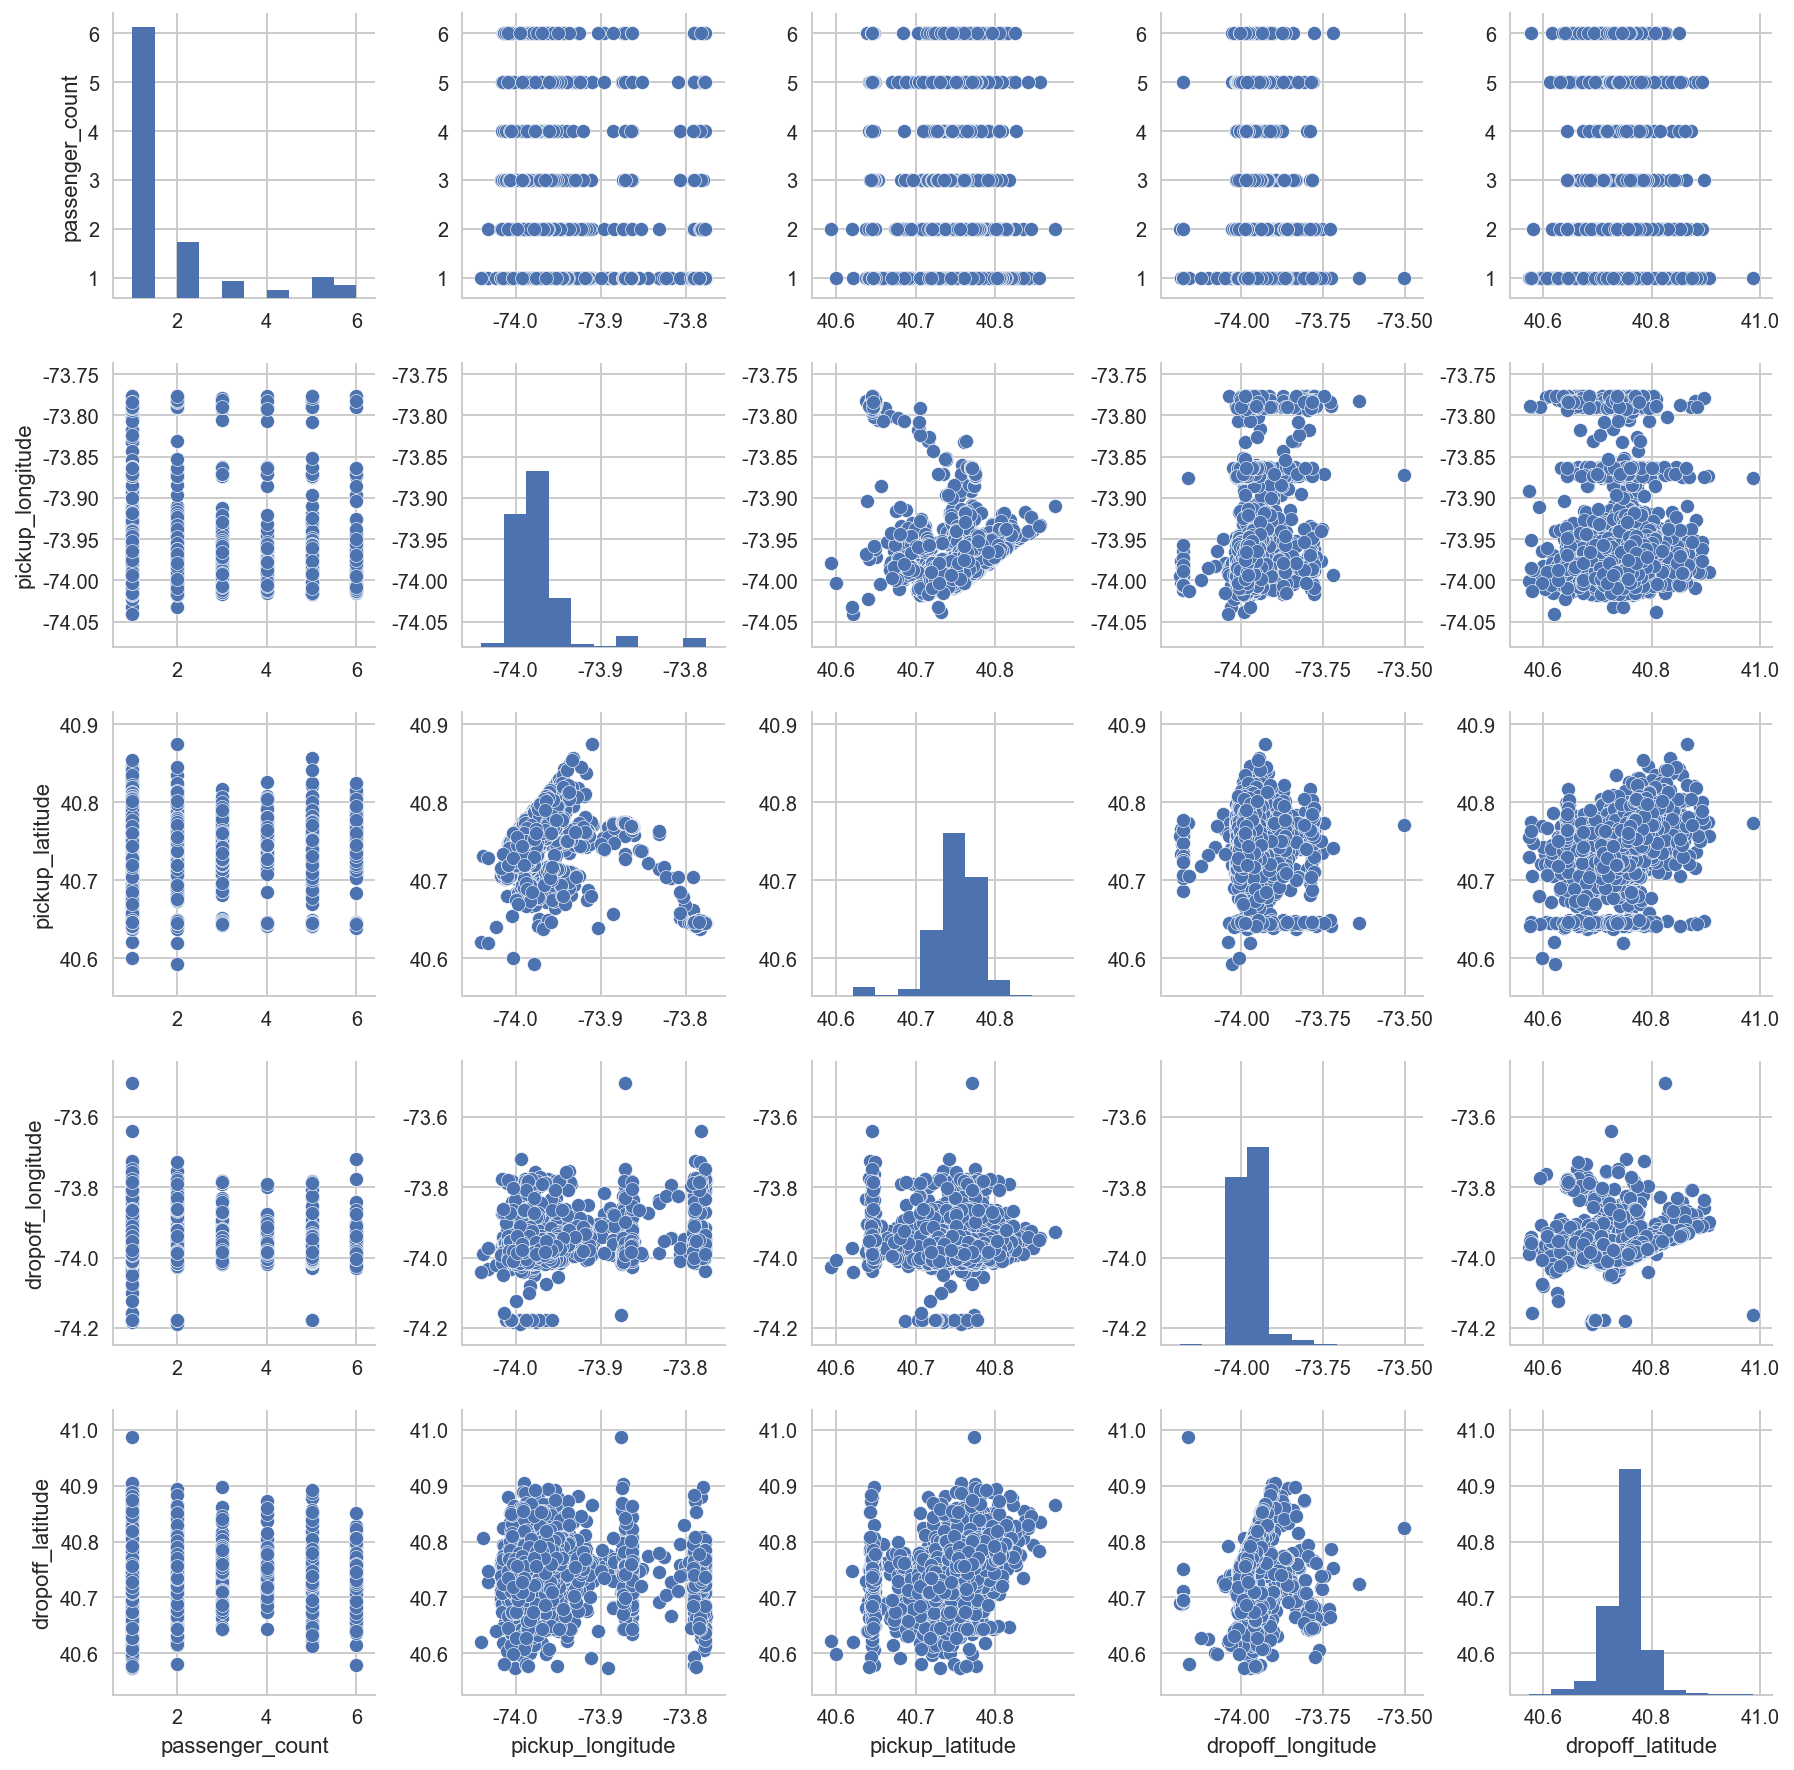

In [61]:
sns.pairplot(train_real_sample)
plt.show()

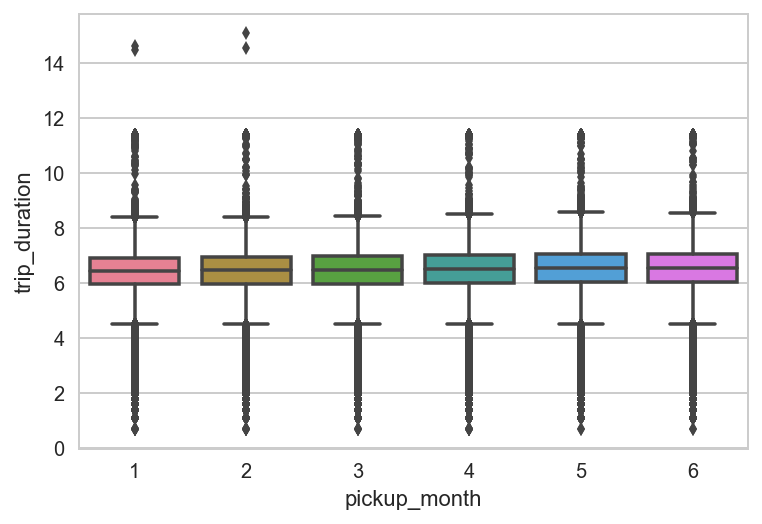

In [51]:
sns.boxplot(x="pickup_month", y=np.log1p(train["trip_duration"]),
            data=train, palette="husl")
plt.show()

In [66]:
model = sm.OLS.from_formula("trip_duration ~ C(pickup_month) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.69
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           2.14e-13
Time:                        18:07:44   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458638   BIC:                         2.912e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(pickup_month)[1]   922.3733     10

In [67]:
model = sm.OLS.from_formula("trip_duration ~ C(pickup_weekday) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.72
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           1.20e-15
Time:                        18:08:23   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458637   BIC:                         2.912e+07
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
C(pickup_weekday)[0]   897.9478 

In [65]:
model = sm.OLS.from_formula("trip_duration ~ C(pickup_hour) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     14.33
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           4.83e-56
Time:                        18:07:11   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458620   BIC:                         2.912e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
C(pickup_hour)[0]    936.6573     22

In [71]:
# pickup_hour를 카테고리값이 아닌 상수로 보고 회귀분석 시험

model = sm.OLS.from_formula("trip_duration ~ pickup_hour", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.86
Date:                Sun, 04 Mar 2018   Prob (F-statistic):           8.31e-06
Time:                        18:11:16   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     918.3992     10.189     90.138      

In [72]:
model = sm.OLS.from_formula("trip_duration ~ C(vendor_id) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sun, 04 Mar 2018   Prob (F-statistic):          8.05e-133
Time:                        18:11:58   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
C(vendor_id)[1]   845.4382      6.358    1

In [73]:
model = sm.OLS.from_formula("trip_duration ~ C(store_and_fwd_flag) + 0", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          trip_duration   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.337
Date:                Sun, 04 Mar 2018   Prob (F-statistic):             0.0373
Time:                        18:12:52   Log-Likelihood:            -1.4561e+07
No. Observations:             1458644   AIC:                         2.912e+07
Df Residuals:                 1458642   BIC:                         2.912e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(store_and_fwd_flag)[N]